In [0]:
!wget ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip
!unzip cell_images.zip

Streaming output truncated to the last 5000 lines.
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_91.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_1

In [0]:
import numpy as np
import tensorflow as tf
# import glob
# import PIL.Image
import os
from matplotlib import pyplot as plt
import cv2
import random

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical,plot_model
from keras.models import Sequential, Model
from keras.layers import InputLayer,Dense, Conv2D,Activation, MaxPooling2D, Flatten, Add, BatchNormalization, Dropout, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.applications import MobileNet, ResNet50

Using TensorFlow backend.


In [0]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [0]:
# images_parasitized = glob.glob('cell_images/Parasitized/*.png')
# images_Uninfected = glob.glob('cell_images/Uninfected/*.png')
# X = np.array([image.img_to_array(PIL.Image.open(img)) for img in images_parasitized + images_Uninfected])
# y = [0] * len(images_parasitized)
# y.extend([1]*len(images_Uninfected))

# 3.1

### A Convolutional Model without Residual connections
#### Trained on original Data without any kind of Data Augmentation

In [0]:
# Creates a model wherein Batch Normalization is applied before introducing Non-linearity
def create_model(num_channels=3,dropout=False, batch_normalization=False):
  model = Sequential()
  model.add(InputLayer(input_shape=(128,128,num_channels)))
  model.add(Conv2D(32, (3, 3)))
  if(batch_normalization):
    model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation("relu"))
  if(batch_normalization):
    model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation("relu"))
  if(batch_normalization):
    model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))

  # model.add(Conv2D(64, (3, 3)))
  # model.add(Activation("relu"))
  # if(batch_normalization):
  #   model.add(BatchNormalization())
  # model.add(MaxPooling2D(pool_size=(2,2)))
  if(dropout):
    model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(128))
  model.add(Activation("relu"))

  model.add(Dense(128))
  model.add(Activation("relu"))

  model.add(Dense(2))
  model.add(Activation("softmax"))

  return model

In [0]:
# # Creates a model wherein Batch Normalization is applied after introducing Non-linearity
def build_model(batch_normalization=False,dropout=False, activation="relu"):
    model = Sequential()
    model.add(InputLayer(input_shape = (128, 128, 3)))
    model.add(Conv2D(32, 3, activation = activation, padding = 'same'))
    if batch_normalization: 
      model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
    if batch_normalization:
       model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
    if batch_normalization: 
      model.add(BatchNormalization())
    # model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
    if batch_normalization: 
      model.add(BatchNormalization()) 
    model.add(MaxPooling2D())
    if(dropout):
      model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation = activation, kernel_initializer = 'he_uniform'))
    model.add(Dense(128, activation = activation, kernel_initializer = 'he_uniform'))
    model.add(Dense(2, activation = 'softmax'))
    return model

In [0]:
DATADIR = "cell_images"
CATEGORIES = ['Parasitized','Uninfected']
IMG_SIZE = 128
training_data = []

def create_training_data_BW():
	for category in CATEGORIES :
		path = os.path.join(DATADIR, category)
		class_num = CATEGORIES.index(category)
		for img in os.listdir(path):
			try :
				img_array = cv2.imread(os.path.join(path, img),cv2.IMREAD_GRAYSCALE)
				new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
				training_data.append([new_array, class_num])
				# fig, axes = plt.subplots(1, 2)
				# plot=[img_array,new_array]
				# for i, ax in enumerate(axes.ravel()):
				# 		ax.imshow(plot[i])
			except Exception as e:
				pass
create_training_data_BW()

In [0]:
X_BW = [] #features
y_BW = [] #labels
for features, label in training_data:
	X_BW.append(features)
	y_BW.append(label)
y_BW = np.array(y_BW)
X_BW = np.array(X_BW).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

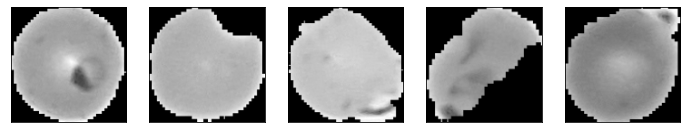

In [0]:
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X_BW[i, :,:,0],cmap='gray')
    ax.set_xticks(())
    ax.set_yticks(())

In [0]:
X_train_val,X_test,y_train_val,y_test = train_test_split(X_BW,y_BW,shuffle=True,stratify=y,test_size=0.25)
X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,shuffle=True,stratify=y_train_val,test_size=0.25)
num_classes = 2
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

In [0]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size= 32

train_generator = train_datagen.flow(X_train,y_train,batch_size=batch_size)
validation_generator = test_datagen.flow(X_val,y_val,batch_size=batch_size)
test_generator = test_datagen.flow(X_test,y_test,batch_size=batch_size)

In [0]:
model_BW = create_model(1,dropout=True)
model_BW.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
print(model_BW.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
activation_49 (Activation)   (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
activation_50 (Activation)   (None, 61, 61, 64)        0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 28, 28, 64)      

In [0]:
history = model_BW.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size))

Epoch 1/10
485/485 [==============================] - 7s 15ms/step - loss: 0.6645 - accuracy: 0.5887 - val_loss: 0.5640 - val_accuracy: 0.7349
Epoch 2/10
485/485 [==============================] - 7s 14ms/step - loss: 0.2403 - accuracy: 0.9108 - val_loss: 0.1273 - val_accuracy: 0.9463
Epoch 3/10
485/485 [==============================] - 7s 14ms/step - loss: 0.1560 - accuracy: 0.9481 - val_loss: 0.1047 - val_accuracy: 0.9490
Epoch 4/10
485/485 [==============================] - 7s 14ms/step - loss: 0.1440 - accuracy: 0.9505 - val_loss: 0.1052 - val_accuracy: 0.9525
Epoch 5/10
485/485 [==============================] - 7s 14ms/step - loss: 0.1242 - accuracy: 0.9562 - val_loss: 0.0978 - val_accuracy: 0.9486
Epoch 6/10
485/485 [==============================] - 7s 14ms/step - loss: 0.1077 - accuracy: 0.9605 - val_loss: 0.0975 - val_accuracy: 0.9472
Epoch 7/10
485/485 [==============================] - 7s 14ms/step - loss: 0.0941 - accuracy: 0.9661 - val_loss: 0.1140 - val_accuracy: 0.9437

In [0]:
score = model_BW.evaluate_generator(test_generator)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.003
Test Accuracy: 0.952


In [0]:
DATADIR = "cell_images"
CATEGORIES = ['Parasitized','Uninfected']
IMG_SIZE = 128
training_data = []

def create_training_data():
	for category in CATEGORIES :
		path = os.path.join(DATADIR, category)
		class_num = CATEGORIES.index(category)
		for img in os.listdir(path):
			try :
				img_array = cv2.imread(os.path.join(path, img))
				new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
				training_data.append([new_array, class_num])
				# fig, axes = plt.subplots(1, 2)
				# plot=[img_array,new_array]
				# for i, ax in enumerate(axes.ravel()):
				# 		ax.imshow(plot[i])
			except Exception as e:
				pass
create_training_data()

In [0]:
X = [] #features
y = [] #labels
for features, label in training_data:
	X.append(features)
	y.append(label)
y = np.array(y)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

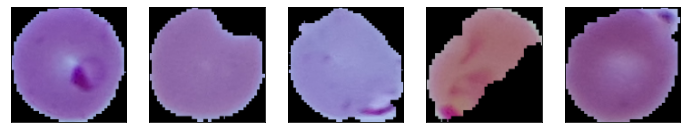

In [0]:
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X[i, :, :])
    ax.set_xticks(())
    ax.set_yticks(())

In [0]:
X_train_val,X_test,y_train_val,y_test = train_test_split(X,y,shuffle=True,stratify=y,test_size=0.25)
X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,shuffle=True,stratify=y_train_val,test_size=0.25)
num_classes = 2
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

In [0]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size= 32

train_generator = train_datagen.flow(X_train,y_train,batch_size=batch_size)
validation_generator = test_datagen.flow(X_val,y_val,batch_size=batch_size)
test_generator = test_datagen.flow(X_test,y_test,batch_size=batch_size)

EarlyStop = EarlyStopping(monitor='val_loss', verbose=1)

In [0]:
model = create_model(dropout=True)
model.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
activation_7 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 61, 61, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)       

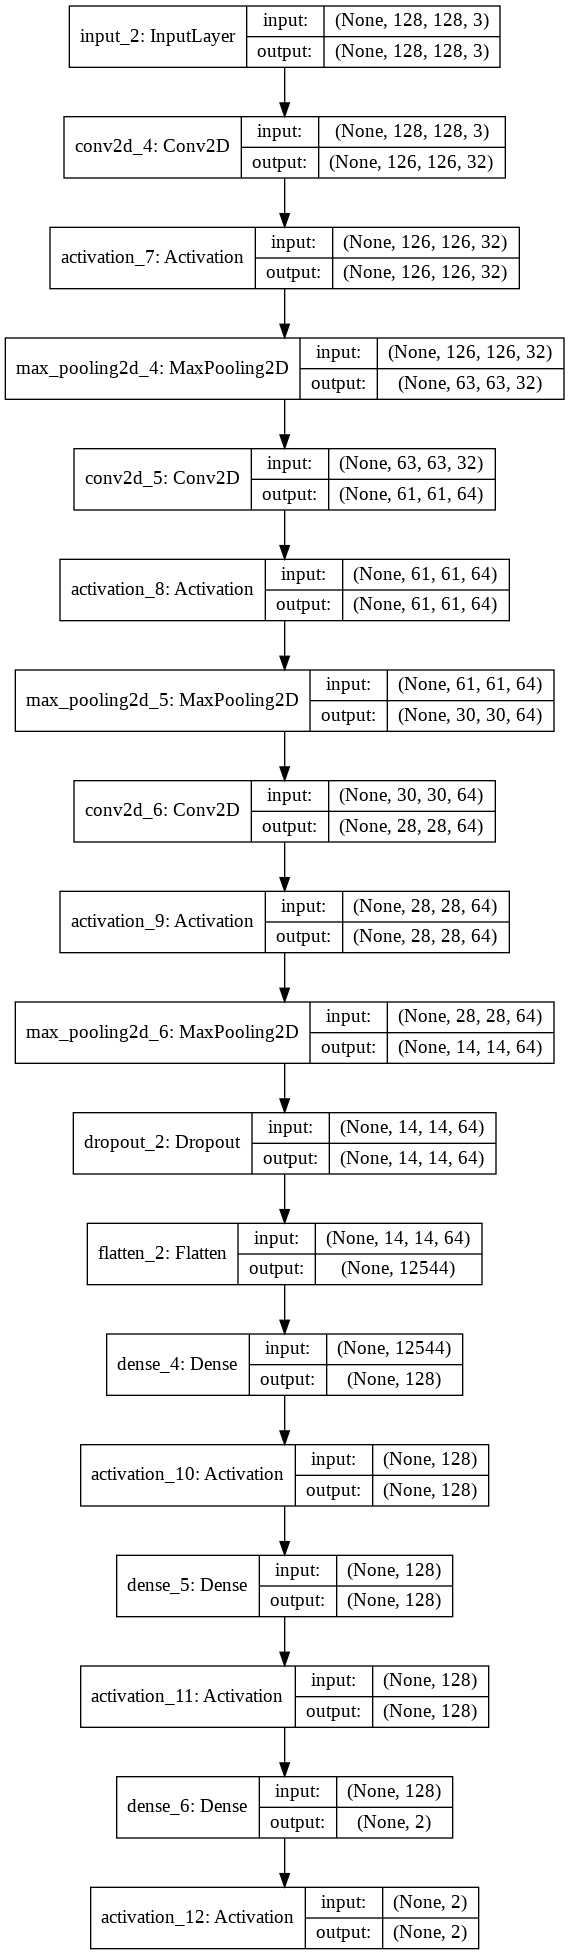

In [0]:
plot_model(model, 'model1.png', show_shapes=True)

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size),
                              callbacks=[EarlyStop])

Epoch 1/10
485/485 [==============================] - 14s 29ms/step - loss: 0.4061 - accuracy: 0.7939 - val_loss: 0.3555 - val_accuracy: 0.9328
Epoch 2/10
485/485 [==============================] - 8s 16ms/step - loss: 0.1766 - accuracy: 0.9439 - val_loss: 0.1229 - val_accuracy: 0.9546
Epoch 3/10
485/485 [==============================] - 8s 16ms/step - loss: 0.1490 - accuracy: 0.9526 - val_loss: 0.1376 - val_accuracy: 0.9503
Epoch 00003: early stopping


In [0]:
score = model.evaluate_generator(test_generator)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.596
Test Accuracy: 0.953


In [0]:
model = create_model(batch_normalization=True,dropout=True)
model.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
activation_13 (Activation)   (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
activation_14 (Activation)   (None, 61, 61, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)       

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size),
                              callbacks=[EarlyStop])

Epoch 1/10
485/485 [==============================] - 16s 34ms/step - loss: 0.3155 - accuracy: 0.8843 - val_loss: 0.3409 - val_accuracy: 0.7838
Epoch 2/10
485/485 [==============================] - 16s 32ms/step - loss: 0.1838 - accuracy: 0.9416 - val_loss: 0.1219 - val_accuracy: 0.9369
Epoch 3/10
485/485 [==============================] - 16s 32ms/step - loss: 0.1613 - accuracy: 0.9478 - val_loss: 0.2389 - val_accuracy: 0.9281
Epoch 00003: early stopping


In [0]:
score = model.evaluate_generator(test_generator)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 1.104
Test Accuracy: 0.927


In [0]:
model = create_model()
model.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
activation_19 (Activation)   (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
activation_20 (Activation)   (None, 61, 61, 64)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 64)       

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size),
                              callbacks=[EarlyStop])

Epoch 1/10
485/485 [==============================] - 8s 16ms/step - loss: 0.4441 - accuracy: 0.7749 - val_loss: 0.1080 - val_accuracy: 0.9377
Epoch 2/10
485/485 [==============================] - 7s 15ms/step - loss: 0.1735 - accuracy: 0.9433 - val_loss: 0.0226 - val_accuracy: 0.9554
Epoch 3/10
485/485 [==============================] - 7s 15ms/step - loss: 0.1319 - accuracy: 0.9574 - val_loss: 0.2043 - val_accuracy: 0.9412
Epoch 00003: early stopping


In [0]:
score = model.evaluate_generator(test_generator)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.328
Test Accuracy: 0.940


In [0]:
model = create_model(batch_normalization=True,dropout=False)
model.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
activation_25 (Activation)   (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
activation_26 (Activation)   (None, 61, 61, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 61, 64)       

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size),
                              callbacks=[EarlyStop])

Epoch 1/10
485/485 [==============================] - 16s 34ms/step - loss: 0.3632 - accuracy: 0.8920 - val_loss: 0.7017 - val_accuracy: 0.7054
Epoch 2/10
485/485 [==============================] - 16s 33ms/step - loss: 0.1768 - accuracy: 0.9392 - val_loss: 0.0825 - val_accuracy: 0.9266
Epoch 3/10
485/485 [==============================] - 16s 33ms/step - loss: 0.1476 - accuracy: 0.9519 - val_loss: 0.1244 - val_accuracy: 0.9459
Epoch 00003: early stopping


In [0]:
score = model.evaluate_generator(test_generator)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.882
Test Accuracy: 0.945


In [0]:
model = build_model(batch_normalization=True,dropout=True)
model.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_15 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 64)      

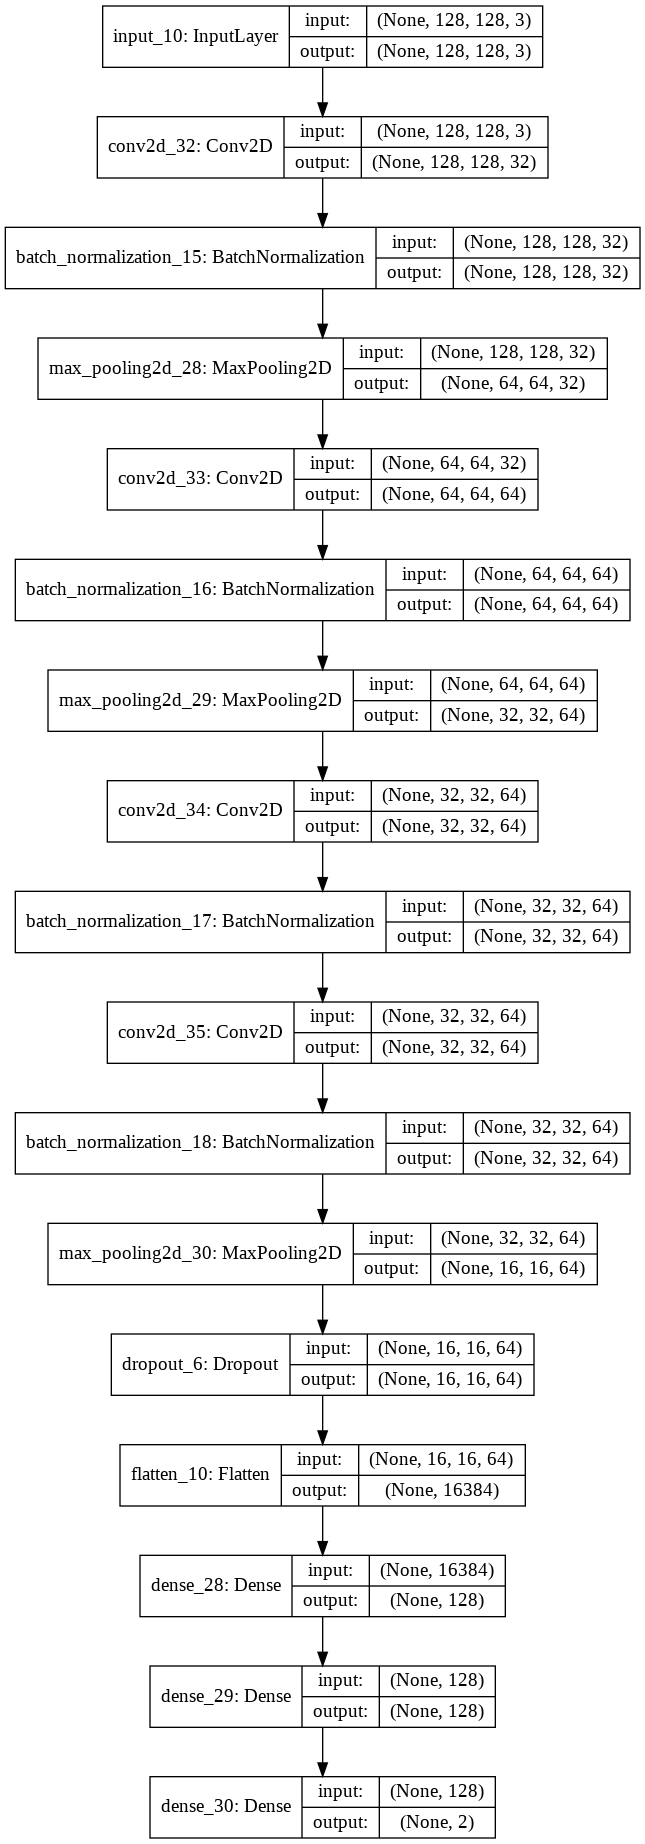

In [0]:
plot_model(model, 'model2.png', show_shapes=True)

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size),
                              callbacks=[EarlyStop])

Epoch 1/10
485/485 [==============================] - 19s 39ms/step - loss: 0.4389 - accuracy: 0.8427 - val_loss: 1.0134 - val_accuracy: 0.6663
Epoch 2/10
485/485 [==============================] - 18s 37ms/step - loss: 0.1806 - accuracy: 0.9417 - val_loss: 0.2911 - val_accuracy: 0.9426
Epoch 3/10
485/485 [==============================] - 18s 37ms/step - loss: 0.1573 - accuracy: 0.9498 - val_loss: 0.2517 - val_accuracy: 0.9486
Epoch 4/10
485/485 [==============================] - 18s 37ms/step - loss: 0.1397 - accuracy: 0.9546 - val_loss: 0.0460 - val_accuracy: 0.9468
Epoch 5/10
485/485 [==============================] - 18s 37ms/step - loss: 0.1279 - accuracy: 0.9561 - val_loss: 0.2136 - val_accuracy: 0.9507
Epoch 00005: early stopping


In [0]:
score = model.evaluate_generator(test_generator)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.578
Test Accuracy: 0.950


In [0]:
model = build_model(batch_normalization=True,dropout=False)
model.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_19 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_20 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 64)      

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size),
                              callbacks=[EarlyStop])

Epoch 1/10
485/485 [==============================] - 18s 38ms/step - loss: 0.4502 - accuracy: 0.8225 - val_loss: 0.5908 - val_accuracy: 0.8564
Epoch 2/10
485/485 [==============================] - 18s 36ms/step - loss: 0.1675 - accuracy: 0.9448 - val_loss: 0.1282 - val_accuracy: 0.9490
Epoch 3/10
485/485 [==============================] - 18s 37ms/step - loss: 0.1551 - accuracy: 0.9494 - val_loss: 0.0476 - val_accuracy: 0.9200
Epoch 4/10
485/485 [==============================] - 18s 36ms/step - loss: 0.1462 - accuracy: 0.9527 - val_loss: 0.1371 - val_accuracy: 0.9544
Epoch 00004: early stopping


In [0]:
score = model.evaluate_generator(test_generator)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.527
Test Accuracy: 0.956


In [0]:
model = build_model(batch_normalization=False,dropout=True)
model.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 64)       

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size),
                              callbacks=[EarlyStop])

Epoch 1/10
485/485 [==============================] - 9s 19ms/step - loss: 0.6841 - accuracy: 0.5796 - val_loss: 0.6390 - val_accuracy: 0.6077
Epoch 2/10
485/485 [==============================] - 9s 18ms/step - loss: 0.3186 - accuracy: 0.8730 - val_loss: 0.2150 - val_accuracy: 0.9554
Epoch 3/10
485/485 [==============================] - 9s 18ms/step - loss: 0.1470 - accuracy: 0.9534 - val_loss: 0.1114 - val_accuracy: 0.9445
Epoch 4/10
485/485 [==============================] - 9s 18ms/step - loss: 0.1217 - accuracy: 0.9613 - val_loss: 0.0312 - val_accuracy: 0.9572
Epoch 5/10
485/485 [==============================] - 9s 18ms/step - loss: 0.1038 - accuracy: 0.9647 - val_loss: 0.5118 - val_accuracy: 0.9593
Epoch 00005: early stopping


In [0]:
score = model.evaluate_generator(test_generator)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.708
Test Accuracy: 0.959


In [0]:
model = build_model(batch_normalization=False,dropout=False)
model.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 16, 16, 64)       

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size),
                              callbacks=[EarlyStop])

Epoch 1/10
485/485 [==============================] - 9s 18ms/step - loss: 0.3832 - accuracy: 0.8216 - val_loss: 0.2117 - val_accuracy: 0.9499
Epoch 2/10
485/485 [==============================] - 8s 17ms/step - loss: 0.1519 - accuracy: 0.9528 - val_loss: 0.3331 - val_accuracy: 0.9533
Epoch 00002: early stopping


In [0]:
score = model.evaluate_generator(test_generator)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.828
Test Accuracy: 0.955


# Summary for models trained on given data
- Model 1: (Applies normalization before introducing non-linearity)
  - With Dropout on grayscale images: 95.2%
  - Batch Normalization: 94.5 %
  - Dropout: 95.3 %
  - Dropout + Batch Normalization: 92.7 %
  - No Dropout + No Batch Normaliatin: 94 %

- Model 2: (Applies normalization after introducing non-linearity and has one more convolution block)
  - Batch Normalization: 95.6 %
  - Dropout: 95.9 %
  - Dropout + Batch Normalization: 95 %
  - No Dropout + No Batch Normaliation: 95.5 %

# 3.2

### A Convolutional Model without Residual connections
#### Trained on original Data with different kind of Data Augmentations

In [0]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=20,
                                   shear_range = 0.2
                                   )
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size= 32

train_generator = train_datagen.flow(X_train,y_train,batch_size=batch_size)
validation_generator = test_datagen.flow(X_val,y_val,batch_size=batch_size)
test_generator = test_datagen.flow(X_test,y_test,batch_size=batch_size)

EarlyStop = EarlyStopping(monitor='val_loss', verbose=1)


In [0]:
model = create_model(dropout=True)
model.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
print(model.summary())

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
activation_91 (Activation)   (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
activation_92 (Activation)   (None, 61, 61, 64)        0         
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 28, 28, 64)      

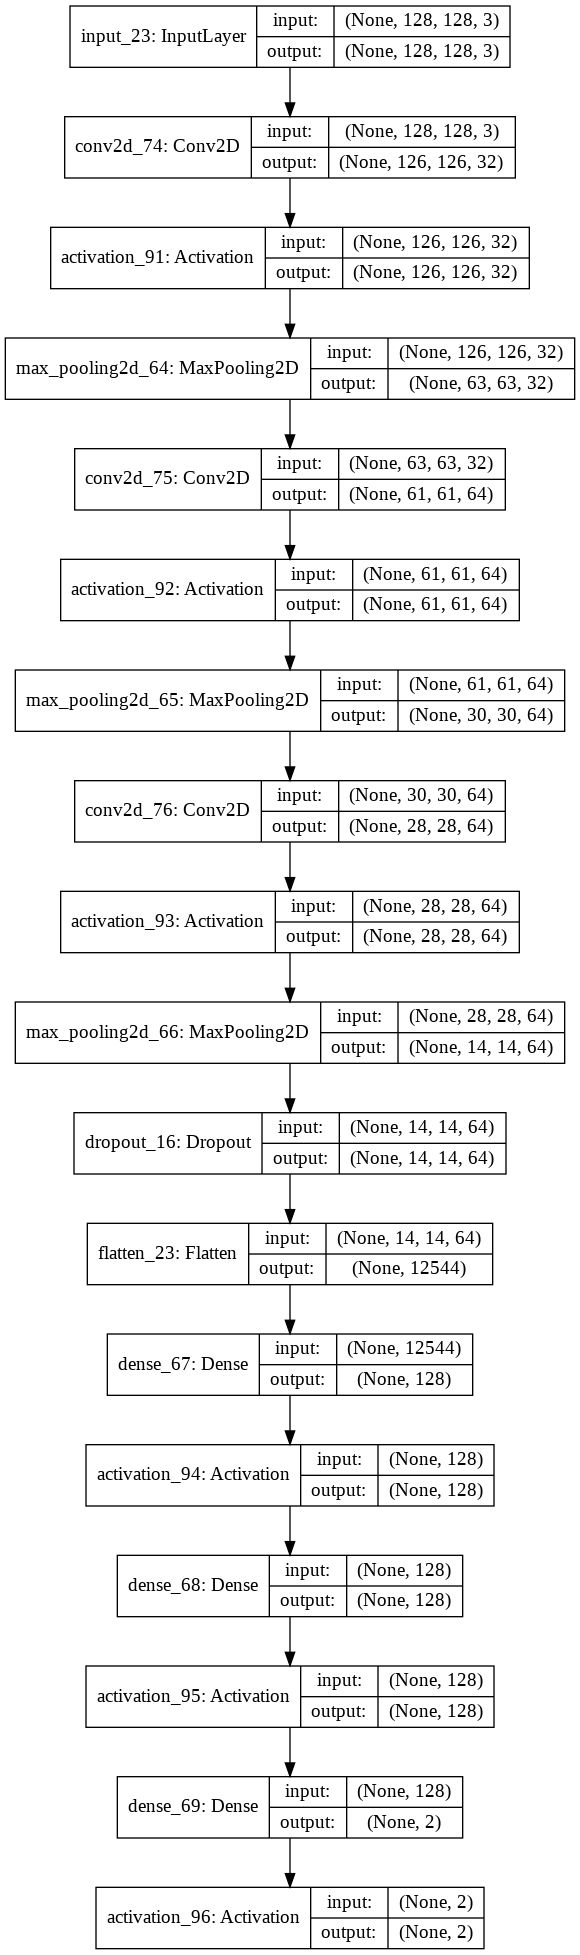

In [0]:
plot_model(model, 'model1.png', show_shapes=True)

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size),
                              callbacks = [EarlyStop])

Epoch 1/10
485/485 [==============================] - 57s 118ms/step - loss: 0.5057 - accuracy: 0.7517 - val_loss: 0.1648 - val_accuracy: 0.9350
Epoch 2/10
485/485 [==============================] - 56s 116ms/step - loss: 0.2012 - accuracy: 0.9380 - val_loss: 0.1050 - val_accuracy: 0.9603
Epoch 3/10
485/485 [==============================] - 57s 117ms/step - loss: 0.1741 - accuracy: 0.9461 - val_loss: 0.0197 - val_accuracy: 0.9558
Epoch 4/10
485/485 [==============================] - 57s 117ms/step - loss: 0.1717 - accuracy: 0.9445 - val_loss: 0.1462 - val_accuracy: 0.9564
Epoch 00004: early stopping


In [0]:
score = model.evaluate_generator(test_generator)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.015
Test Accuracy: 0.955


In [0]:
model = create_model(batch_normalization=True,dropout=True)
model.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
print(model.summary())

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_33 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
activation_97 (Activation)   (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
activation_98 (Activation)   (None, 61, 61, 64)        0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 61, 61, 64)      

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size),
                              callbacks = [EarlyStop])

Epoch 1/10
485/485 [==============================] - 60s 123ms/step - loss: 0.3494 - accuracy: 0.8660 - val_loss: 0.4347 - val_accuracy: 0.7733
Epoch 2/10
485/485 [==============================] - 58s 120ms/step - loss: 0.2256 - accuracy: 0.9286 - val_loss: 0.1037 - val_accuracy: 0.9509
Epoch 3/10
485/485 [==============================] - 58s 120ms/step - loss: 0.1919 - accuracy: 0.9385 - val_loss: 0.2815 - val_accuracy: 0.9219
Epoch 00003: early stopping


In [0]:
score = model.evaluate_generator(test_generator)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.129
Test Accuracy: 0.920


In [0]:
model = create_model()
model.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
print(model.summary())

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
activation_103 (Activation)  (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
activation_104 (Activation)  (None, 61, 61, 64)        0         
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 28, 28, 64)      

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size),
                              callbacks = [EarlyStop])

Epoch 1/10
485/485 [==============================] - 57s 118ms/step - loss: 0.4431 - accuracy: 0.8079 - val_loss: 0.2183 - val_accuracy: 0.9373
Epoch 2/10
485/485 [==============================] - 56s 116ms/step - loss: 0.2428 - accuracy: 0.9254 - val_loss: 0.2042 - val_accuracy: 0.9575
Epoch 3/10
485/485 [==============================] - 56s 116ms/step - loss: 0.1863 - accuracy: 0.9440 - val_loss: 0.2581 - val_accuracy: 0.9589
Epoch 00003: early stopping


In [0]:
score = model.evaluate_generator(test_generator)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.034
Test Accuracy: 0.953


In [0]:
model = create_model(batch_normalization=True,dropout=False)
model.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
print(model.summary())

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_36 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
activation_109 (Activation)  (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
activation_110 (Activation)  (None, 61, 61, 64)        0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 61, 61, 64)      

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size),
                              callbacks = [EarlyStop])

Epoch 1/10
485/485 [==============================] - 60s 123ms/step - loss: 0.4414 - accuracy: 0.8360 - val_loss: 0.6421 - val_accuracy: 0.7248
Epoch 2/10
485/485 [==============================] - 59s 121ms/step - loss: 0.2365 - accuracy: 0.9182 - val_loss: 0.0356 - val_accuracy: 0.9348
Epoch 3/10
485/485 [==============================] - 59s 121ms/step - loss: 0.2127 - accuracy: 0.9288 - val_loss: 0.2929 - val_accuracy: 0.9116
Epoch 00003: early stopping


In [0]:
score = model.evaluate_generator(test_generator)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.070
Test Accuracy: 0.915


In [0]:
model = build_model(batch_normalization=True,dropout=True)
model.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)       

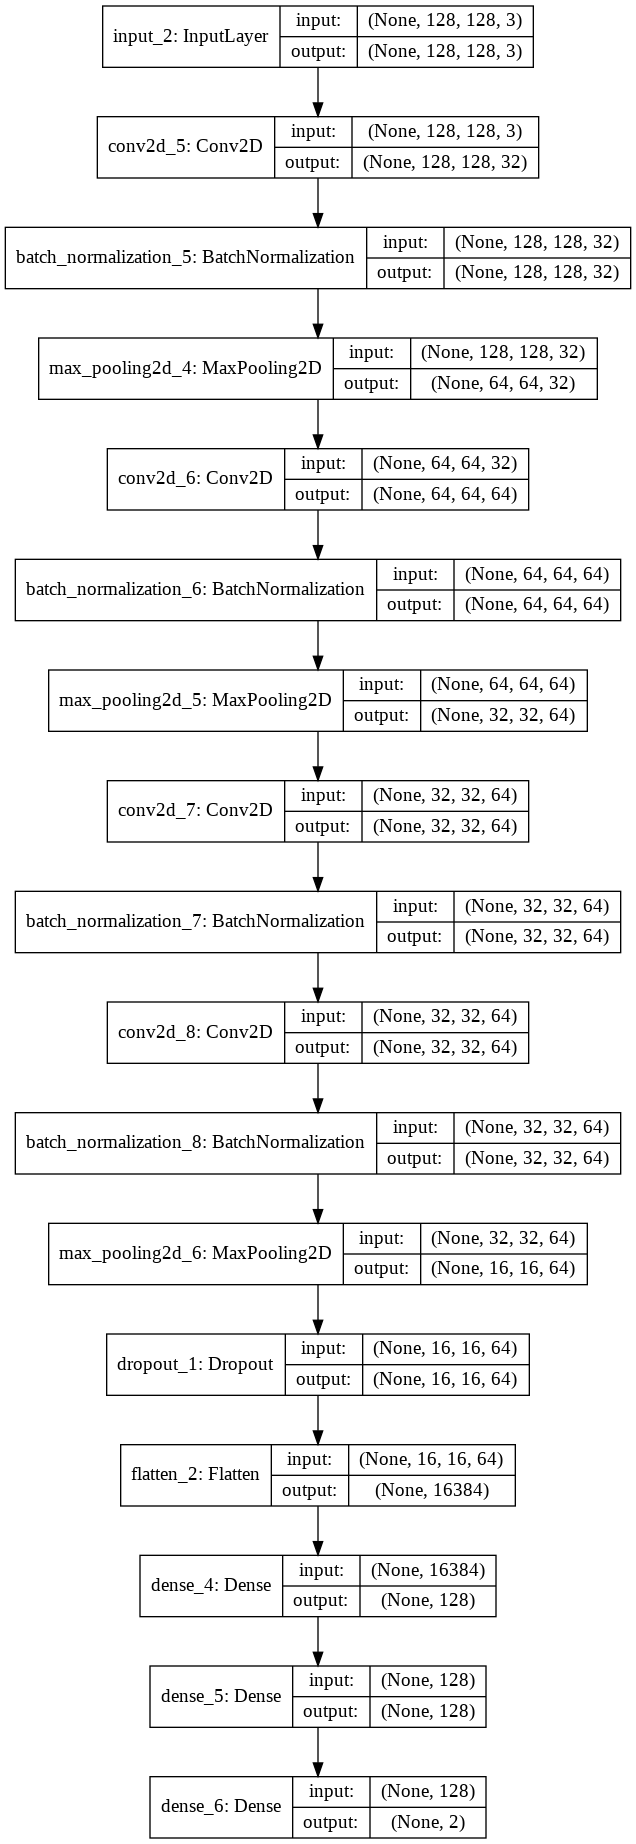

In [0]:
plot_model(model, 'model2.png', show_shapes=True)

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size),
                              callbacks = [EarlyStop])

Epoch 1/10
485/485 [==============================] - 63s 131ms/step - loss: 0.8385 - accuracy: 0.7492 - val_loss: 0.4507 - val_accuracy: 0.7642
Epoch 2/10
485/485 [==============================] - 62s 129ms/step - loss: 0.2241 - accuracy: 0.9268 - val_loss: 0.2527 - val_accuracy: 0.9387
Epoch 3/10
485/485 [==============================] - 63s 129ms/step - loss: 0.2060 - accuracy: 0.9336 - val_loss: 0.0741 - val_accuracy: 0.9457
Epoch 4/10
485/485 [==============================] - 63s 129ms/step - loss: 0.1886 - accuracy: 0.9401 - val_loss: 0.2060 - val_accuracy: 0.9262
Epoch 00004: early stopping


In [0]:
score = model.evaluate_generator(test_generator)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.016
Test Accuracy: 0.937


In [0]:
model = build_model(batch_normalization=True,dropout=False)
model.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
print(model.summary())

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_43 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_44 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 32, 32, 64)      

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size),
                              callbacks = [EarlyStop])

Epoch 1/10
485/485 [==============================] - 61s 125ms/step - loss: 0.5263 - accuracy: 0.7928 - val_loss: 0.7971 - val_accuracy: 0.5450
Epoch 2/10
485/485 [==============================] - 59s 121ms/step - loss: 0.2027 - accuracy: 0.9362 - val_loss: 0.4414 - val_accuracy: 0.9217
Epoch 3/10
485/485 [==============================] - 59s 122ms/step - loss: 0.1966 - accuracy: 0.9378 - val_loss: 0.1446 - val_accuracy: 0.9503
Epoch 4/10
485/485 [==============================] - 59s 122ms/step - loss: 0.1823 - accuracy: 0.9399 - val_loss: 0.0159 - val_accuracy: 0.9453
Epoch 5/10
485/485 [==============================] - 59s 122ms/step - loss: 0.1725 - accuracy: 0.9445 - val_loss: 0.1385 - val_accuracy: 0.9507
Epoch 00005: early stopping


In [0]:
score = model.evaluate_generator(test_generator)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.035
Test Accuracy: 0.951


In [0]:
model = build_model(batch_normalization=False,dropout=True)
model.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
print(model.summary())

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 16, 16, 64)      

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size),
                              callbacks = [EarlyStop])

Epoch 1/10
485/485 [==============================] - 58s 120ms/step - loss: 0.3289 - accuracy: 0.8671 - val_loss: 0.1153 - val_accuracy: 0.9464
Epoch 2/10
485/485 [==============================] - 57s 118ms/step - loss: 0.1806 - accuracy: 0.9457 - val_loss: 0.0836 - val_accuracy: 0.9533
Epoch 3/10
485/485 [==============================] - 57s 117ms/step - loss: 0.1665 - accuracy: 0.9498 - val_loss: 0.0441 - val_accuracy: 0.9591
Epoch 4/10
485/485 [==============================] - 57s 117ms/step - loss: 0.1618 - accuracy: 0.9495 - val_loss: 0.0372 - val_accuracy: 0.9542
Epoch 5/10
485/485 [==============================] - 57s 117ms/step - loss: 0.1593 - accuracy: 0.9503 - val_loss: 0.0943 - val_accuracy: 0.9568
Epoch 00005: early stopping


In [0]:
score = model.evaluate_generator(test_generator)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.038
Test Accuracy: 0.954


In [0]:
model = build_model(batch_normalization=False,dropout=False)
model.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
print(model.summary())

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 16, 16, 64)      

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size),
                              callbacks = [EarlyStop])

Epoch 1/10
485/485 [==============================] - 58s 119ms/step - loss: 0.4117 - accuracy: 0.8027 - val_loss: 0.1811 - val_accuracy: 0.9521
Epoch 2/10
485/485 [==============================] - 56s 116ms/step - loss: 0.1859 - accuracy: 0.9430 - val_loss: 0.0341 - val_accuracy: 0.9564
Epoch 3/10
485/485 [==============================] - 57s 117ms/step - loss: 0.1634 - accuracy: 0.9506 - val_loss: 0.1041 - val_accuracy: 0.9595
Epoch 00003: early stopping


In [0]:
score = model.evaluate_generator(test_generator)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.025
Test Accuracy: 0.953


# Summary for models trained on  Augmented Data
- Model 1: (Applies normalization before introducing non-linearity)
  - Batch Normalization: 91.5 %
  - Dropout: 95.5 %
  - Dropout + Batch Normalization: 92 %
  - No Dropout + No Batch Normaliation: 95.3 %

- Model 2: (Applies normalization after introducing non-linearity and has one more convolution block)
  - Batch Normalization: 95.1 %
  - Dropout: 95.4 %
  - Dropout + Batch Normalization: 93.7 %
  - No Dropout + No Batch Normaliation: 95.3 %

# 3.3

### Comparision of deep ResNet architecture with and without Residual Connections while the rest of the architecture is constant

In [0]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=20,
                                   shear_range = 0.2
                                   )
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size= 32

train_generator = train_datagen.flow(X_train,y_train,batch_size=batch_size)
validation_generator = test_datagen.flow(X_val,y_val,batch_size=batch_size)
test_generator = test_datagen.flow(X_test,y_test,batch_size=batch_size)

EarlyStop = EarlyStopping(monitor='val_loss', verbose=1)

In [0]:


# # The code block for building the Resnet block for the building the architecture taken from https://github.com/alinarw/ResNet/blob/master/ResNet.ipynb
       
# # Resuidal block BN -> relu -> conv -> bn -> relu -> conv
# def res_block(x, filters,skip=True):
#     bn1 = BatchNormalization()(x)
#     act1 = Activation('relu')(bn1)
#     conv1 = Conv2D(filters=filters, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_uniform')(act1)
#     bn2 = BatchNormalization()(conv1)
#     act2 = Activation('relu')(bn2)
#     conv2 = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform')(act2)
#     residual = Conv2D(1, (1, 1), strides=(1, 1))(conv2)
#     if skip:
#       x = Conv2D(filters=filters, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_uniform')(x)
#       out = Add()([x, residual])
#     else:
#       out = residual
#     return out

In [0]:
# input1 = Input(shape=(128, 128, 3))
# res1 = res_block(input1, 64,skip=False)
# res2 = res_block(res1, 128,skip=False)
# res3 = res_block(res2, 256,skip=False)
# # res4 = res_block(res3, 512,skip=False)
# act1 = Activation('relu')(res3)
# flatten1 = Flatten()(act1)
# dense1 = Dense(512)(flatten1)
# act2 = Activation('relu')(dense1)
# dense2 = Dense(128)(act2)
# act3 = Activation('relu')(dense2)
# dense3 = Dense(2)(act3)
# output1 = Activation('softmax')(dense3)
# model_wo_skip_conn_1 = Model(inputs=input1, outputs=output1)

# # Compiling the model
# model_wo_skip_conn_1.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

### With Skip Connections

In [0]:
from keras.layers import add
inputs = Input(shape=(128, 128, 3))
conv1_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(inputs)
conv1_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv1_1)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1_2)
conv2_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool1)
conv2_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv2_1)
skip2 = add([maxpool1, conv2_2])
maxpool2 = MaxPooling2D(pool_size=(2, 2))(skip2)
# flat = Flatten()(maxpool2)
# dense1 = Dense(64, activation='relu')(flat)

conv1_1_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool2)
conv1_1_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv1_1_1)
maxpool1_1 = MaxPooling2D(pool_size=(2, 2))(conv1_1_2)
conv1_2_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool1_1)
conv1_2_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv1_2_1)
skip1_2 = add([maxpool1_1, conv1_2_2])
maxpool1_2 = MaxPooling2D(pool_size=(2, 2))(skip1_2)
# flat1 = Flatten()(maxpool1_2)
# dense2 = Dense(64, activation='relu')(flat1)

conv2_1_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool1_2)
conv2_1_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv2_1_1)
maxpool2_1 = MaxPooling2D(pool_size=(2, 2))(conv2_1_2)
conv2_2_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool2_1)
conv2_2_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv2_2_1)
skip2_2 = add([maxpool2_1, conv2_2_2])
maxpool2_2 = MaxPooling2D(pool_size=(2, 2))(skip2_2)
flat2 = Flatten()(maxpool2_2)
dense3 = Dense(64, activation='relu')(flat2)

predictions = Dense(num_classes, activation='softmax')(dense3)
model_w = Model(inputs=inputs, outputs=predictions)

In [0]:
model_w.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
history_w = model_w.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size))

Epoch 1/10
485/485 [==============================] - 55s 113ms/step - loss: 0.3768 - accuracy: 0.8098 - val_loss: 0.0278 - val_accuracy: 0.9517
Epoch 2/10
485/485 [==============================] - 49s 100ms/step - loss: 0.1714 - accuracy: 0.9465 - val_loss: 0.0359 - val_accuracy: 0.9572
Epoch 3/10
485/485 [==============================] - 48s 99ms/step - loss: 0.1630 - accuracy: 0.9493 - val_loss: 0.1237 - val_accuracy: 0.9585
Epoch 4/10
485/485 [==============================] - 48s 100ms/step - loss: 0.1623 - accuracy: 0.9483 - val_loss: 0.1257 - val_accuracy: 0.9570
Epoch 5/10
485/485 [==============================] - 48s 100ms/step - loss: 0.1593 - accuracy: 0.9501 - val_loss: 0.0946 - val_accuracy: 0.9570
Epoch 6/10
485/485 [==============================] - 49s 100ms/step - loss: 0.1542 - accuracy: 0.9514 - val_loss: 0.0318 - val_accuracy: 0.9577
Epoch 7/10
485/485 [==============================] - 49s 100ms/step - loss: 0.1521 - accuracy: 0.9516 - val_loss: 0.0459 - val_acc

In [0]:
model_w.evaluate_generator(test_generator)

[0.028029460459947586, 0.9596516489982605]

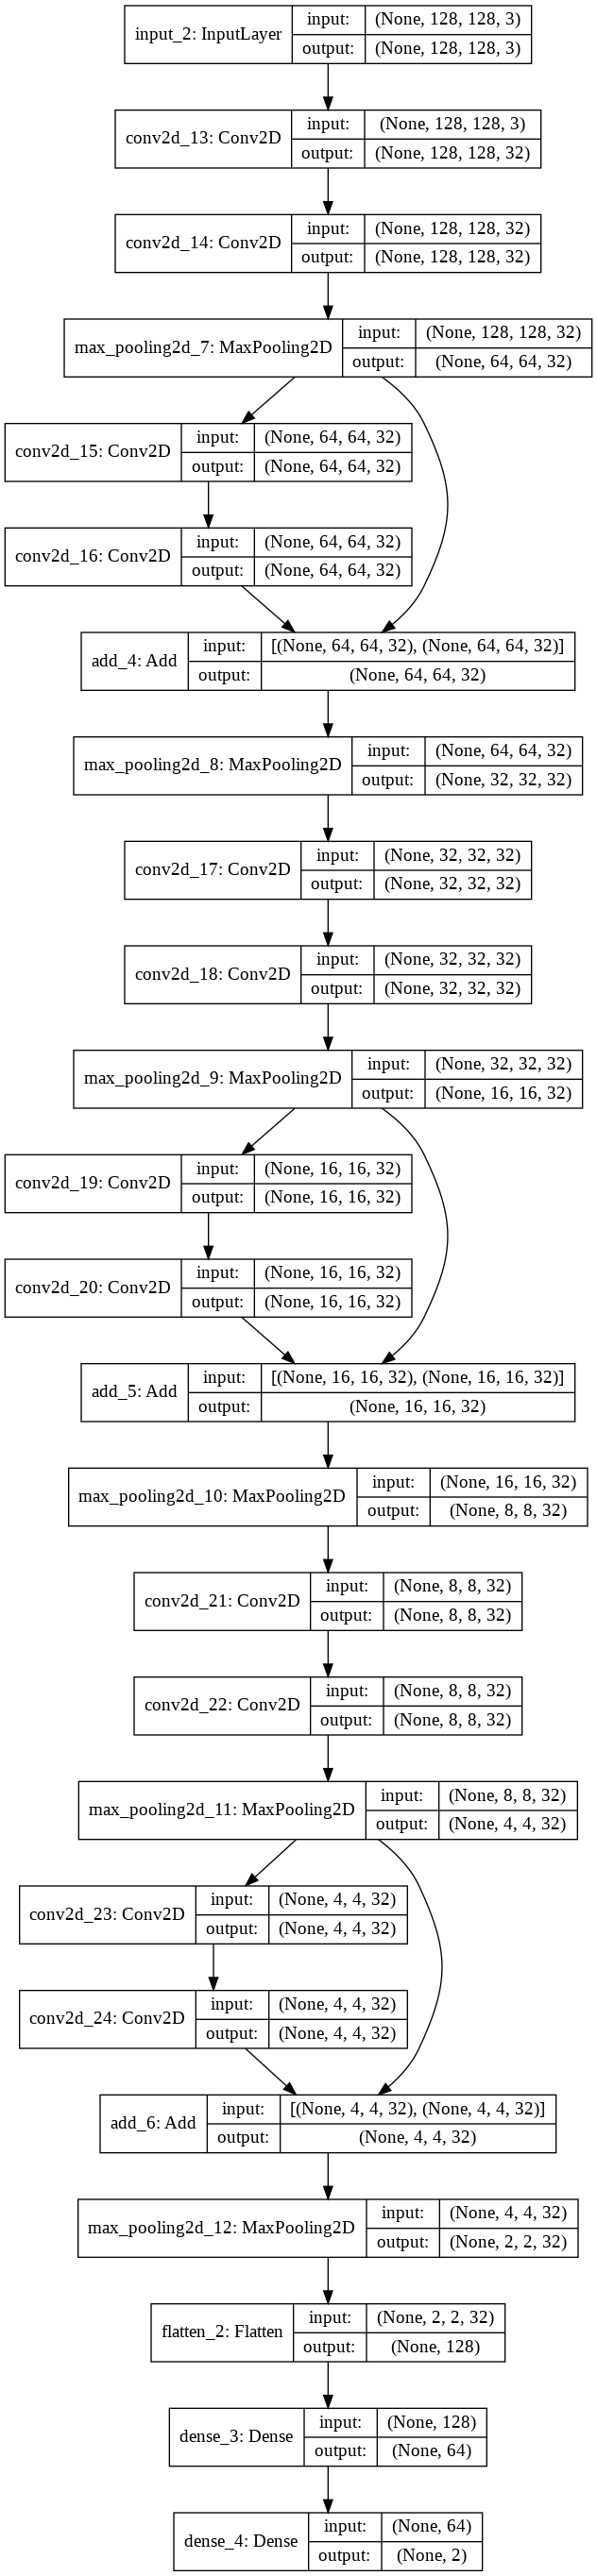

In [0]:
plot_model(model_w, show_shapes=True)

In [0]:
from keras.layers import add
inputs = Input(shape=(128, 128, 3))
conv1_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(inputs)
b1 = BatchNormalization()(conv1_1)
conv1_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(b1)
b2 = BatchNormalization()(conv1_2)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(b2)
conv2_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool1)
b3 = BatchNormalization()(conv2_1)                 
conv2_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(b3)
b4 = BatchNormalization()(conv2_2) 
skip2 = add([maxpool1, b4])
maxpool2 = MaxPooling2D(pool_size=(2, 2))(skip2)


conv1_1_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool2)
b5 = BatchNormalization()(conv1_1_1)
conv1_1_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(b5)
b6 = BatchNormalization()(conv1_1_2)
maxpool1_1 = MaxPooling2D(pool_size=(2, 2))(b6)
conv1_2_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool1_1)
b7 = BatchNormalization()(conv1_2_1)
conv1_2_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(b7)
b8 = BatchNormalization()(conv1_2_2)
skip1_2 = add([maxpool1_1, b8])
maxpool1_2 = MaxPooling2D(pool_size=(2, 2))(skip1_2)

conv2_1_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool1_2)
b9 = BatchNormalization()(conv2_1_1)
conv2_1_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(b9)
b10 = BatchNormalization()(conv2_1_2)
maxpool2_1 = MaxPooling2D(pool_size=(2, 2))(b10)
conv2_2_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool2_1)
b11 = BatchNormalization()(conv2_2_1)
conv2_2_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(b11)
b12 = BatchNormalization()(conv2_2_2)
skip2_2 = add([maxpool2_1, b12])
maxpool2_2 = MaxPooling2D(pool_size=(2, 2))(skip2_2)
flat2 = Flatten()(maxpool2_2)
dense3 = Dense(64, activation='relu')(flat2)

predictions = Dense(num_classes, activation='softmax')(dense3)
model_wb = Model(inputs=inputs, outputs=predictions)

In [0]:
model_wb.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
history_wb = model_wb.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size))

Epoch 1/10
485/485 [==============================] - 55s 112ms/step - loss: 0.3646 - accuracy: 0.8487 - val_loss: 0.2645 - val_accuracy: 0.9082
Epoch 2/10
485/485 [==============================] - 52s 108ms/step - loss: 0.1856 - accuracy: 0.9410 - val_loss: 0.0824 - val_accuracy: 0.9554
Epoch 3/10
485/485 [==============================] - 52s 107ms/step - loss: 0.1665 - accuracy: 0.9452 - val_loss: 0.0139 - val_accuracy: 0.9494
Epoch 4/10
485/485 [==============================] - 52s 107ms/step - loss: 0.1609 - accuracy: 0.9479 - val_loss: 0.0490 - val_accuracy: 0.9542
Epoch 5/10
485/485 [==============================] - 52s 108ms/step - loss: 0.1523 - accuracy: 0.9483 - val_loss: 0.2720 - val_accuracy: 0.9552
Epoch 6/10
485/485 [==============================] - 52s 107ms/step - loss: 0.1439 - accuracy: 0.9511 - val_loss: 0.2621 - val_accuracy: 0.9531
Epoch 7/10
485/485 [==============================] - 52s 108ms/step - loss: 0.1411 - accuracy: 0.9545 - val_loss: 0.3361 - val_ac

In [0]:
model_wb.evaluate_generator(test_generator)

[0.050909943878650665, 0.9593613743782043]

### Without Skip Connections

In [0]:
from keras.layers import add
inputs = Input(shape=(128, 128, 3))
conv1_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(inputs)
conv1_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv1_1)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1_2)
conv2_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool1)
conv2_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv2_1)
# skip2 = add([maxpool1, conv2_2])


conv1_1_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv2_2)
conv1_1_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv1_1_1)
maxpool1_1 = MaxPooling2D(pool_size=(2, 2))(conv1_1_2)
conv1_2_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool1_1)
conv1_2_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv1_2_1)
# skip1_2 = add([maxpool1_1, conv1_2_2])


conv2_1_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv1_2_2)
conv2_1_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv2_1_1)
maxpool2_1 = MaxPooling2D(pool_size=(2, 2))(conv2_1_2)
conv2_2_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(maxpool2_1)
conv2_2_2 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(conv2_2_1)
# skip2_2 = add([maxpool2_1, conv2_2_2])
maxpool2_2 = MaxPooling2D(pool_size=(2, 2))(conv2_2_2)
flat2 = Flatten()(maxpool2_2)
dense3 = Dense(64, activation='relu')(flat2)

predictions = Dense(num_classes, activation='softmax')(dense3)
model_wo = Model(inputs=inputs, outputs=predictions)

In [0]:
model_wo.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
history_wo = model_wo.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size))

Epoch 1/10
485/485 [==============================] - 50s 103ms/step - loss: 0.6933 - accuracy: 0.4983 - val_loss: 0.6950 - val_accuracy: 0.4994
Epoch 2/10
485/485 [==============================] - 49s 101ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6952 - val_accuracy: 0.4989
Epoch 3/10
485/485 [==============================] - 49s 101ms/step - loss: 0.6932 - accuracy: 0.4929 - val_loss: 0.6932 - val_accuracy: 0.5009
Epoch 4/10
485/485 [==============================] - 49s 100ms/step - loss: 0.6932 - accuracy: 0.4879 - val_loss: 0.6937 - val_accuracy: 0.4993
Epoch 5/10
485/485 [==============================] - 49s 101ms/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6926 - val_accuracy: 0.4999
Epoch 6/10
485/485 [==============================] - 49s 100ms/step - loss: 0.6932 - accuracy: 0.4963 - val_loss: 0.6939 - val_accuracy: 0.4972
Epoch 7/10
485/485 [==============================] - 49s 100ms/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6947 - val_ac

In [0]:
model_wo.evaluate_generator(test_generator)

[0.6951764822006226, 0.5]

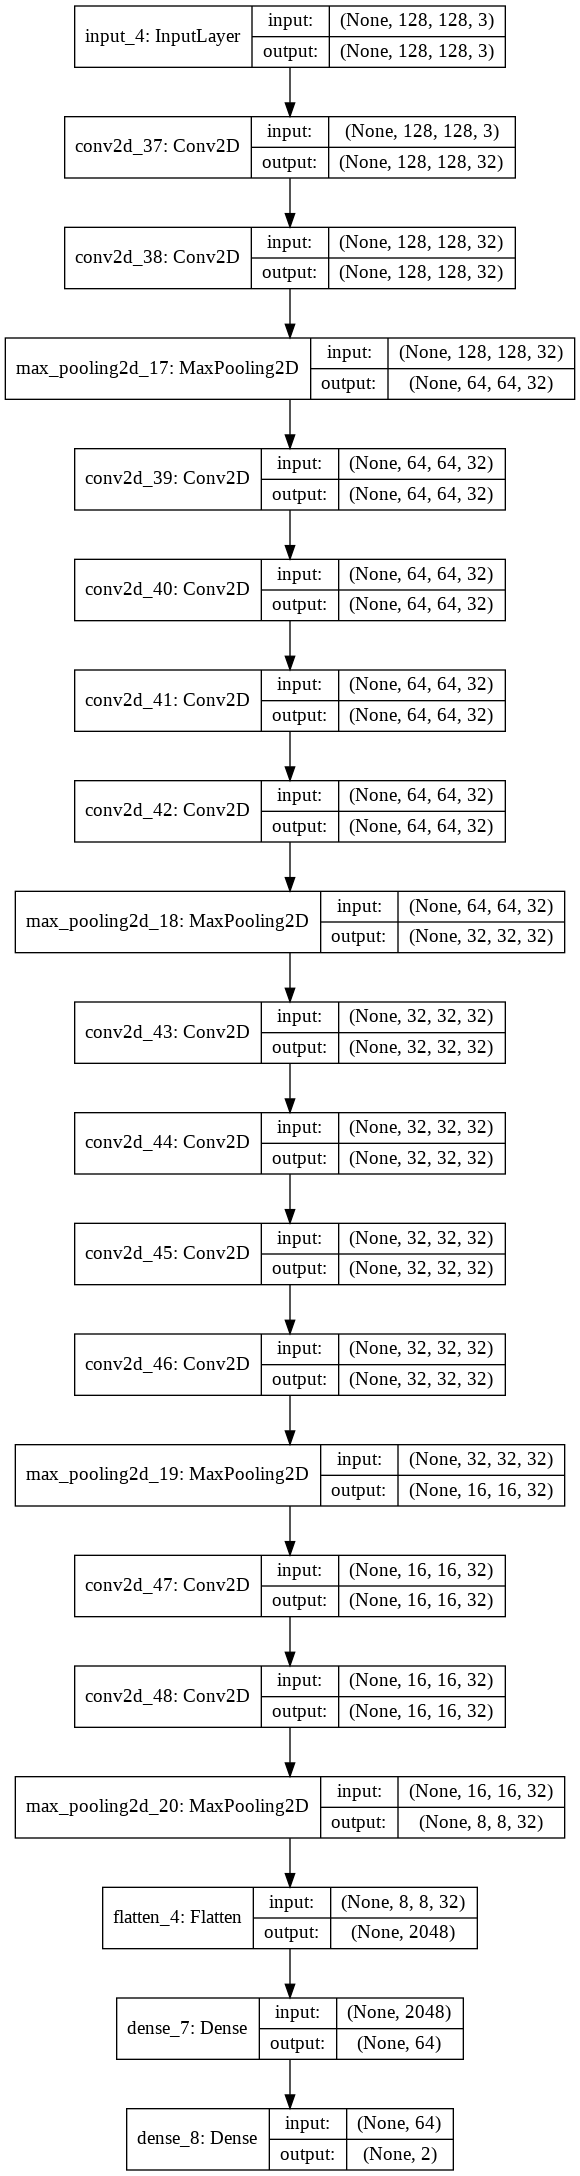

In [0]:
plot_model(model_wo, show_shapes=True)

Thus, we can see that here the model with skip connections performs much better than the one without skip connections.

# 3.4

### Transfer Learning with MobileNet

In [0]:
mobile_net = MobileNet(input_shape=(128,128,3), weights='imagenet',include_top=True)
mobile_net.layers.pop()
mobile_net.layers.pop()

x = mobile_net.layers[-1].output
x = Flatten()(x)
x = Activation("relu")(x)
x= Dense(256,activation="relu")(x)
x=Dense(512,activation='relu')(x)
output = Dense(2,activation="softmax")(x)

model = Model(mobile_net.input,output)
for i in model.layers[:-5]:
  i.trainable = False

In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

In [0]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=20,
                                   shear_range = 0.2
                                   )
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size= 32

train_generator = train_datagen.flow(X_train,y_train,batch_size=batch_size)
validation_generator = test_datagen.flow(X_val,y_val,batch_size=batch_size)
test_generator = test_datagen.flow(X_test,y_test,batch_size=batch_size)

EarlyStop = EarlyStopping(monitor='val_loss', verbose=1)

In [0]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
history = model.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size),
                              callbacks=[EarlyStop])

Epoch 1/10
485/485 [==============================] - 60s 125ms/step - loss: 0.3278 - accuracy: 0.8647 - val_loss: 0.9607 - val_accuracy: 0.6755
Epoch 2/10
485/485 [==============================] - 53s 110ms/step - loss: 0.2551 - accuracy: 0.8972 - val_loss: 0.5950 - val_accuracy: 0.7334
Epoch 3/10
485/485 [==============================] - 53s 110ms/step - loss: 0.2424 - accuracy: 0.9048 - val_loss: 0.5953 - val_accuracy: 0.7638
Epoch 4/10
485/485 [==============================] - 53s 110ms/step - loss: 0.2412 - accuracy: 0.9066 - val_loss: 1.2237 - val_accuracy: 0.6837
Epoch 5/10
485/485 [==============================] - 53s 109ms/step - loss: 0.2344 - accuracy: 0.9068 - val_loss: 0.7620 - val_accuracy: 0.8012
Epoch 6/10
485/485 [==============================] - 53s 110ms/step - loss: 0.2377 - accuracy: 0.9045 - val_loss: 0.8911 - val_accuracy: 0.7525
Epoch 7/10
485/485 [==============================] - 53s 109ms/step - loss: 0.2188 - accuracy: 0.9140 - val_loss: 0.2873 - val_ac

In [0]:
score = model.evaluate_generator(test_generator)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.056
Test Accuracy: 0.783


In [0]:
mobile_net = MobileNet(input_shape=(128,128,3), weights='imagenet',include_top=True)
mobile_net.layers.pop()
mobile_net.layers.pop()

x = mobile_net.layers[-1].output
x = Flatten()(x)
x = Activation("relu")(x)
x= Dense(256,activation="relu")(x)
x=Dense(512,activation='relu')(x)
output = Dense(2,activation="softmax")(x)

model = Model(mobile_net.input,output)

In [0]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

In [0]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=20,
                                   shear_range = 0.2
                                   )
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size= 32

train_generator = train_datagen.flow(X_train,y_train,batch_size=batch_size)
validation_generator = test_datagen.flow(X_val,y_val,batch_size=batch_size)
test_generator = test_datagen.flow(X_test,y_test,batch_size=batch_size)

EarlyStop = EarlyStopping(monitor='val_loss', verbose=1)

In [0]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
history = model.fit_generator(train_generator,
                              steps_per_epoch = np.ceil(len(X_train)/batch_size),
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=(len(X_val)//batch_size),
                              callbacks=[EarlyStop])

Epoch 1/10
485/485 [==============================] - 62s 129ms/step - loss: 0.2064 - accuracy: 0.9359 - val_loss: 0.0938 - val_accuracy: 0.9616
Epoch 2/10
485/485 [==============================] - 58s 119ms/step - loss: 0.1506 - accuracy: 0.9506 - val_loss: 0.1284 - val_accuracy: 0.9646
Epoch 3/10
485/485 [==============================] - 57s 118ms/step - loss: 0.1321 - accuracy: 0.9561 - val_loss: 0.0744 - val_accuracy: 0.9675
Epoch 4/10
485/485 [==============================] - 57s 118ms/step - loss: 0.1265 - accuracy: 0.9557 - val_loss: 0.0483 - val_accuracy: 0.9671
Epoch 5/10
485/485 [==============================] - 57s 118ms/step - loss: 0.1240 - accuracy: 0.9561 - val_loss: 0.0853 - val_accuracy: 0.9690
Epoch 6/10
485/485 [==============================] - 58s 119ms/step - loss: 0.1178 - accuracy: 0.9593 - val_loss: 0.1051 - val_accuracy: 0.9669
Epoch 7/10
485/485 [==============================] - 57s 117ms/step - loss: 0.1128 - accuracy: 0.9605 - val_loss: 0.0538 - val_ac

In [0]:
score = model.evaluate_generator(test_generator)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.271
Test Accuracy: 0.970
